In [1]:
# Import necessary functions.
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from scipy.interpolate import interp2d
import warnings

In [4]:
# Initialize the Model class which will perform the stellar modelling.
class Model:
    """
    This class contains all constants, functions, flags and conditions required to model a 1-dimensional
    profile of the internal structure of the star, including the pressure, density, temperature, and
    method of energy transport. This class plots all of these parameters and a cross-sections of
    the star.

    In the __init__(self) function, set your initial conditions and enable any desired flags.
    """
    
    # Define constants, initial parameters, flags of the model. -----------------------|
    def __init__(self):

        """
        FILEPATHS FOR opacity.txt and epsilon.txt.
        """
        # Make sure you have set the correct file path.
        self.filepath_opacity = "opacity.txt"
        self.filepath_epsilon = "epsilon.txt"

        """
        SANITY CHECK FLAGS.
        """
        # Set to true to perform the opacity/epsilon sanity checks.
        self.opacity_sanity_check_option = False
        self.epsilon_sanity_check_option = False

        # Initialize constants.
        self.G = const.G.value # [m^3 / (kg * s^2)]
        self.pi = np.pi
        self.k_B = const.k_B.value # [J/K]
        self.sigma = const.sigma_sb.value # [W / (m^2 K^4)]
        self.c = const.c.value # [m / s]
        self.m_u = const.u.value # [kg]
        self.M_sun = const.M_sun.value # [kg]
        self.R_sun = const.R_sun.value # [m]
        self.L_sun = const.L_sun.value # [W]
        self.T_sun = 5770
        self.rho_sun = 1.408*1e3 # [kg m^-3]
        X = 0.7 # Hydrogen fraction.
        Y = 0.29 + 1e-10 # Helium fraction.
        Z = 1 - (X + Y) # Metals fraction.
        self.mu = (2*X + 3*Y/4 + Z/2)**-1 # Mean atomic weight.
        self.C_p = (5*self.k_B)/(2*self.mu*self.m_u) # Heat capacity. [J/K]
        self.P_sun = self.P(self.T_sun, self.rho_sun)
        
        # SET INITIAL PARAMETERS <<<<<<<<
        #Define initial parameters: SUN'S PARAMETERS
        
        # self.L_0 = 1.0*self.L_sun
        # self.R_0 = 1.0*self.R_sun
        # self.M_0 = 1.0*self.M_sun
        # self.rho_0 = 1.0*1.42*1e-7*self.rho_sun
        # self.T_0 = 1.0*self.T_sun #Kelvin
        # self.P_0 = self.P(self.T_0, self.rho_0)

        # BEST CONDITIONS
        
        self.L_0 = 1.0*self.L_sun
        self.R_0 = 1.0*self.R_sun
        self.M_0 = 0.97*self.M_sun
        self.rho_0 = 2000.0*1.42*1e-7*self.rho_sun
        self.T_0 = 10.0*self.T_sun #Kelvin
        self.P_0 = self.P(self.T_0, self.rho_0)

        # Initialize step counter to track the final approximation step.
        self.fin_step = 0
    
    # DEFINE FUNCTIONS ----------------------------------------------------|
    def P(self, T, rho):
        """
        Calculate the total pressure as the sum of radiation and gas pressure.

        Input:
            T (float): Temperature.
            rho (float): Density.
        Output:
            (float): Pressure.
        """
        left = (4*self.sigma*(T**4))/(3*self.c)
        right = (rho*self.k_B*T)/(self.mu*self.m_u)
        return left+right

    def rho(self, P, T):
        """
        Calculate the density of the system.

        Input:
            P (float): Pressure.
            T (float): Temperature.
        Output:
            (float): Density.
        """
        left = (4*self.sigma*(T**4))/(3*self.c)
        right = (self.mu*self.m_u)/(self.k_B*T)
        return (P-left)*right
        
    def g(self, m, r):
        """
        Calculate the gravity of the system.

        Input:
            m (float): Mass.
            r (float): Radius.
        Output:
            (float): Gravity.
        """
        numerator = self.G*m
        denominator = r**2
        return numerator/denominator
    
    def H_p(self, T, g):
        """
        Calculate the scale height of the system.

        Input:
            T (float): Temperature.
            g (float): Gravity.
        Output:
            (float) Scale height.
        """
        numerator = self.k_B*T
        denominator = self.mu*self.m_u*g
        return numerator/denominator

    def flux(self, r, L):
        """
        Calculate the total flux of the system.

        Input:
            r (float): Radius.
            L (float): Luminosity.
        Output:
            (float): Flux.
        """
        denominator = 4*self.pi*(r**2)
        return L/denominator

    def rad_flux(self, rho, kappa, T, H_p, temp_grad):
        """
        Calculate the radiative flux of the system.

        Input:
            rho (float): Density.
            kappa (float): Opacity.
            T (float): Temperature.
            H_p (float): Scale height.
            temp_grad (float): Temperature gradient.
        Output:
            (float): Radiative flux.
        """
        numerator = 16*self.sigma*(T**4)
        denominator = 3*rho*kappa*H_p*temp_grad
        return numerator/denominator

    def conv_flux(self, flux, rad_flux):
        """
        Calculate the convective flux of the system.

        Input:
            flux (float): Total flux.
            rad_flux (float): Radiative flux.
        """
        return flux - rad_flux
    
    def grad_stable(self, kappa, H_p, L, r, T, rho):
        """
        Calculate the stable temperature gradient.

        Input:
            kappa (float): Opacity.
            H_p (float): Scale height.
            L (float): Luminosity.
            r (float): Radius.
            T (float): Temperature.
            rho (float): Density.
        Output:
            (float): Stable temperature gradient.
        """
        numerator = 3*kappa*H_p*L*rho
        denominator = 64*self.pi*(r**2)*self.sigma*(T**4)
        return numerator/denominator

    def grad_adiabatic(self, P, T, rho):
        """
        Calculate the adiabatic temperature gradient.

        Input:
            P (float): Pressure.
            T (float): Temperature.
            rho (float): Density.
        Output:
            (float): Adiabatic temperature gradient.
        """
        numerator = P
        denominator = T*rho*self.C_p
        return numerator/denominator

    def grad_star(self, T, H_p, g, kappa, rho, grad_stable, grad_adiabatic):
        """
        Calculate the convective temperature gradient. This is done by solving the roots of a 3rd
        3rd degree polynomial, then selects the root with the minimum imaginary part (i.e. the most
        "real" root). Finally the root is used to calculate the convective temperature gradient.

        Input:
            T (float): Temperature.
            H_p (float): Scale height.
            g (float): Gravity.
            kappa (float): Opacity.
            rho (float): Density.
            grad_stable (float): Stable temperature gradient.
            grad_adiabatic (float): Adiabatic temperature gradient.
        Output:
            (float): Convective temperature gradient.
        """
        # Calculate U.
        U_numerator = 64*self.sigma*(T**3)*np.sqrt(H_p/g)
        U_denominator = 3*kappa*(rho**2)*self.C_p
        U = U_numerator/U_denominator

        # Define l_m and omega.
        l_m = H_p
        omega = 4/l_m

        # Define the 3rd degree polynomial.
        coeff = [1, U/(l_m**2), (U**2 * omega)/(l_m**3), (U/l_m**2)*(grad_adiabatic - grad_stable)]

        # Calculate the roots of the polynomial (there will be more than one).
        roots = np.roots(coeff)
        # Find the root with the minimum imaginary component.
        min_imag_root = min(roots, key=lambda r: np.abs(np.imag(r)))
        # Take the real part of that root.
        xi = np.real(min_imag_root)

        # Calculate the stable temperature gradient.
        gradStar = xi**2 + ((U*omega)/l_m)*xi + grad_adiabatic

        return gradStar

    # DEFINE THE DIFFERENTIAL EQUATIONS ------------------------------------|
    def dr_dm(self, r, rho):
        """
        Calculates the radius differential with respect to mass.

        Input:
            r (float): Radius.
            rho (float): Density.
        Output:
            (float) dr/dm.
        """
        denominator = 4*self.pi*(r**2)*rho
        return 1/denominator

    def dP_dm(self, r, m):
        """
        Calculates the pressure differential with respect to mass.

        Input:
            r (float): Radius.
            m (float): Mass.
        Output:
            (float): dP/dm
        """
        numerator = -self.G*m
        denominator = 4*self.pi*(r**4)
        return numerator/denominator

    def dT_dm(self, kappa, L, r, T): # For when convection is NOT stable
        """
        For the project, there are two differential equations for temperature. This function
        calculates the temperature differential for when convection is NOT stable.

        Input:
            kappa (float): Opacity.
            L (float): Luminosity.
            r (float): Radius.
            T (float): Temperature.
        Output:
            (float): dT/dm.
        """
        numerator = -3*kappa*L
        denominator = 256*(self.pi**2)*self.sigma*(r**4)*(T**3)
        return numerator/denominator

    def read_opacity(self):
        """
        Reads the opacity.txt file and returns the log(R), log(T), and log(kappa) values.

        Input:
            N/A
        Output:
            Three numpy arrays containing log(R), log(T), and log(kappa).
        """
        # MAKE SURE TO SET self.filepath_opacity TO WHERE YOU STORE YOUR opacity.txt FILE!
        with open(self.filepath_opacity, "r") as file:
            # Read log(R) values from the first line into a numpy array.
            R_log = np.asarray(file.readline().split()[1:], dtype=np.float64)

            # Skip the second line since it's blank.
            file.readline()

            # Initialize empty lists to store values.
            T_log = []
            kappa_log = []

            # Iterate through the rows and pull the log(T) and log(kappa) values.
            for row in file:
                T_log.append(float(row.split()[0]))
                kappa_log.append(row.split()[1:])

            # Close the file.
            file.close()

        # Turn the lists into numpy arrays.
        T_log = np.array(T_log)
        kappa_log = np.array(kappa_log)

        return R_log, T_log, kappa_log

    def calc_opacity(self, T, rho):
        """
        This takes the input T and rho to interpolate the opacity, kappa. If the input values are not found
        within the opacity.txt file, linear 2D interpolation is performed to find the best kappa.
        Input:
            T (float): Input temperature.
            rho (float): Input density.
        Output:
            (float): Opacity.
        """

        # Pull the log(R), log(T), and log(kappa) values from the opacity.txt file.
        R_log, T_log, kappa_log = self.read_opacity()

        # This is here to ignore a warning from the interp2d function.
        warnings.filterwarnings('ignore')

        # Setup the interpolator.
        interp = interp2d(R_log, T_log, kappa_log, kind='linear')

        # Interpolate opacity given the input T and rho.
        R_log_input = np.log10( (rho*1e-3)/ (T / 1e6)**3)
        T_log_input = np.log10(T)
        kappa = interp(R_log_input, T_log_input)[0]

        # Print warnings if either of the input parameters are out of bounds of the file and extrapolation occurs.
        if T_log_input < T_log.min() or T_log_input > T_log.max():
            print("Opacity Interpolator: Input TEMPERATURE values out of bounds. Extrapolating...")
        if R_log_input < R_log.min() or R_log_input > R_log.max():
            print("Opacity Interpolator: Input DENSITY values out of bounds. Extrapolating...")

        # Perform unit conversions for the calculated kappa.
        kappa_fin = 10**kappa * 0.1

        # Check if the opacity_sanity_check_option is set to true. If so, run the sanity check.
        if self.opacity_sanity_check_option:
            self.opacity_sanity_check()
        
        return kappa_fin

    def opacity_sanity_check(self):
        """
        Performs a sanity check with provided T, R, and kappa values to verify the opacity interpolator is
        functioning properly. This function runs the interpolator on the provided values and verifies accuracy
        by comparing the calculated opacity against the provided opacity values.

        Input:
            N/A
        Output:
            Print statements stating accuracy of interpolator and if it passed the check.
        """

        # Provided reference values: log(T), R (cgs), kappa (cgs) and kappa (SI).
        T_log10_ref = [3.750, 3.755, 3.755, 3.755, 3.755, 3.770, 3.780, 3.795, 3.770, 3.775, 3.780, 3.795, 3.800]
        R_cgs_ref = [-6.00, -5.95, -5.80, -5.70, -5.55, -5.95, -5.95, -5.95, -5.80, -5.75, -5.70, -5.55, -5.50]
        kappa_cgs_ref = [-1.55, -1.51, -1.57, -1.61, -1.67, -1.33, -1.20, -1.02, -1.39, -1.35, -1.31, -1.16, -1.11]
        kappa_SI_ref = [2.84, 3.11, 2.68, 2.46, 2.12, 4.70, 6.25, 9.45, 4.05, 4.43, 4.94, 6.89, 7.69]

        # Read the opacity.txt file and initialize interpolator.
        log_R, log_T, log_kappa = self.read_opacity()
        interp = interp2d(log_R, log_T, log_kappa, kind='linear')

        # Initialize empty lists to store values.
        kappa_cgs_interp = []
        kappa_SI_interp = []

        # Iterate through the reference R and T values and perform interpolation for kappa in cgs and convert to SI.
        for R_cgs_input, T_log10_input in zip(R_cgs_ref, T_log10_ref):
            kap_cgs = interp(R_cgs_input, T_log10_input)[0]
            kappa_cgs_interp.append(kap_cgs)
            kappa_SI_interp.append(10**kap_cgs * 0.1 *1e3)

        # Iterate through each kappa reference value and check if interpolated values are within 5% of reference.
        for i in range(len(kappa_cgs_ref)):
            cgs_check = np.abs(kappa_cgs_interp[i] - kappa_cgs_ref[i]) <= 0.05 * np.abs(kappa_cgs_ref[i])
            SI_check = np.abs(kappa_SI_interp[i] - kappa_SI_ref[i]) <= 0.05 * np.abs(kappa_SI_ref[i])

            # If both checks are within 5%, print out PASS statements.
            if cgs_check and SI_check:
                print(f"PASSED: Calculations within 5%.")
                print(f"For log10(T) = {T_log10_ref[i]} and log10(R) = {R_cgs_ref[i]}:")
                print(f"INTERPOLATED Opacity: [cgs] = {kappa_cgs_interp[i]} and [SI] = {kappa_SI_interp[i]}")
                print(f"REFERENCE Opacity: [cgs] = {kappa_cgs_ref[i]} and [SI] = {kappa_SI_ref[i]}")
                print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

            # If either check fails, print out FAIL statements.
            else:
                print(f"FAILED: Calculations NOT within 5%.")
                print(f"For log10(T) = {T_log10_ref[i]} and log10(R) = {R_cgs_ref[i]}:")
                print(f"INTERPOLATED Opacity: [cgs] = {kappa_cgs_interp[i]} and [SI] = {kappa_SI_interp[i]}")
                print(f"REFERENCE Opacity: [cgs] = {kappa_cgs_ref[i]} and [SI] = {kappa_SI_ref[i]}")
                print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    def read_epsilon(self):
        """
        Reads the epsilon.txt file and returns the log(R), log(T), and log(epsilon) values.

        Input:
            N/A
        Output:
            Three numpy arrays containing log(R), log(T), and log(epsilon).
        """
        # MAKE SURE TO SET self.filepath_epsilon TO WHERE YOU STORE YOUR epsilon.txt FILE!
        with open(self.filepath_epsilon, "r") as file:
            # Read log(R) values from the first line into a numpy array.
            R_log = np.asarray(file.readline().split()[1:], dtype=np.float64)

            # Skip the second line since it's blank.
            file.readline()

            # Initialize empty lists to store values.
            T_log = []
            epsilon_log = []

            # Iterate through the rows and pull the log(T) and log(epsilon) values.
            for row in file:
                T_log.append(float(row.split()[0]))
                epsilon_log.append(row.split()[1:])

            # Close the file.
            file.close()

        # Turn the lists into numpy arrays.
        T_log = np.array(T_log)
        epsilon_log = np.array(epsilon_log)

        return R_log, T_log, epsilon_log
        # print(f"log_R: {log_R}, log_T: {log_T}, log_epsilon: {log_epsilon}") #Check if reading properly

    def calc_epsilon(self, T, rho):
        """
        This takes the input T and rho to interpolate epsilon. If the input values are not found
        within the epsilon.txt file, linear 2D interpolation is performed to find the best epsilon.
        Input:
            T (float): Input temperature.
            rho (float): Input density.
        Output:
            (float): Epsilon, the total energy released from fusion reactions in the core.
        """
        # Pull the log(R), log(T), and log(epsilon) values from the epsilon.txt file.
        R_log, T_log, epsilon_log = self.read_epsilon()

        # This is here to ignore a warning from the interp2d function.
        warnings.filterwarnings('ignore')

        # Setup the interpolator.
        interp = interp2d(R_log, T_log, epsilon_log, kind='linear')

        # Interpolate the opacity given the input T and rho.
        R_log_input = np.log10( (rho*1e-3)/ (T / 1e6)**3)
        T_log_input = np.log10(T)
        epsilon = interp(R_log_input, T_log_input)[0]

        # Print warnings if either of the input parameters are out of bounds of the file and extrapolation occurs.
        if T_log_input < T_log.min() or T_log_input > T_log.max():
            print("Epsilon Interpolator: Input TEMPERATURE values out of bounds. Extrapolating...")
        if R_log_input < R_log.min() or R_log_input > R_log.max():
            print("Epsilon Interpolator: Input DENSITY values out of bounds. Extrapolating...")

        # Perform unit conversions for the calculated epsilon.
        epsilon_fin = 10**epsilon * 1e-4

        # Check if the epsilon_sanity_check_option is set to true. If so, run the sanity check.
        if self.epsilon_sanity_check_option:
            self.epsilon_sanity_check()
        
        return epsilon_fin


    def epsilon_sanity_check(self):
        # Provided reference values: log(T), R (cgs), epsilon (cgs) and epsilon (SI).
        T_log10_ref = [3.750, 3.755]
        R_cgs_ref = [-6.00, -5.95]
        epsilon_cgs_ref = [-87.995, -87.623]
        epsilon_SI_ref = [1.012, 2.415]

        # Read the opacity.txt file and initialize interpolator.
        log_R, log_T, log_epsilon = self.read_epsilon()
        interp = interp2d(log_R, log_T, log_epsilon, kind='linear')

        # Initialize empty lists to store values.
        epsilon_cgs_interp = []
        epsilon_SI_interp = []

        # Iterate through the reference R and T values and perform interpolation for epsilon in cgs and convert to SI.
        for R_cgs_input, T_log10_input in zip(R_cgs_ref, T_log10_ref):
            eps_cgs = interp(R_cgs_input, T_log10_input)[0]
            epsilon_cgs_interp.append(eps_cgs)
            epsilon_SI_interp.append((10**eps_cgs) * 1e-4 * 1e92)

        # Iterate through each epsilon reference value and check if interpolated values are within 5% of reference.
        for i in range(len(epsilon_cgs_ref)):
            cgs_check = np.abs(epsilon_cgs_interp[i] - epsilon_cgs_ref[i]) <= 0.05 * np.abs(epsilon_cgs_ref[i])
            SI_check = np.abs(epsilon_SI_interp[i] - epsilon_SI_ref[i]) <= 0.05 * np.abs(epsilon_SI_ref[i])

            # If both checks are within 5%, print out PASS statements.
            if cgs_check and SI_check:
                print(f"PASSED: Calculations within 5%.")
                print(f"For log10(T) = {T_log10_ref[i]} and log10(R) = {R_cgs_ref[i]}:")
                print(f"INTERPOLATED Epsilon: [cgs] = {epsilon_cgs_interp[i]} and [SI] = {epsilon_SI_interp[i]}")
                print(f"REFERENCE Epsilon: [cgs] = {epsilon_cgs_ref[i]} and [SI] = {epsilon_SI_ref[i]}")
                print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

            # If either check fails, print out FAIL statements.
            else:
                print(f"FAILED: Calculations NOT within 5%.")
                print(f"For log10(T) = {T_log10_ref[i]} and log10(R) = {R_cgs_ref[i]}:")
                print(f"INTERPOLATED Epsilon: [cgs] = {epsilon_cgs_interp[i]} and [SI] = {epsilon_SI_interp[i]}")
                print(f"REFERENCE Epsilon: [cgs] = {epsilon_cgs_ref[i]} and [SI] = {epsilon_SI_ref[i]}")
                print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    def mass_step(self, L, T, r, P, epsilon, dr_dm, dP_dm, dT_dm):
        """
        Calculate the step size the variables L, T, r, and P are allowed to take with each step by
        finding the minimum mass step that keeps the change in variable below 1% of the variable at
        the current step.
        Input:
            L (float): Luminosity.
            T (float): Temperature.
            r (float): Radius.
            P (float): Pressure.
            epsilon (float): Epsilon.
            dr_dm (float): Radius differential with respect to mass (dr/dm).
            dP_dm (float): Pressure differential with respect to mass (dP/dm).
            dT_dm (float): Temperature differential with respect to mass (dT/dm).
        Output:
            (float): The calculated mass step size.
        """
        # Create an array of the evaluated functions for the current step, and take the absolute value.
        functions = np.array([epsilon, dT_dm, dr_dm, dP_dm])
        functions = np.abs(functions)

        # Create an array of the variables of the current step.
        variables = np.array([L, T, r, P])

        # Calculate the mass step.
        m_step = np.min(0.01 * variables/functions)

        # Limit the mass step to rougly half of Msun to keep it from being too large.
        if m_step < 1e15:
            m_step = 1e15
        return m_step

    def ODE_euler(self):
        """
        Perform euler approximation to generate the stellar model. This function uses the Euler method to approximate
        ODE's that describe the stellar interior. These approximations happen in under a fixed amount of steps (1e5),
        and the evolution of parameters are recorded and returned. This function also returns print statements depending
        on the success of the approximations. This approximation works from the surface of the star towards the core.

        Input:
            N/A
        Output:
            r (float): Radius.
            m (float): Mass.
            rho (float): Density.
            P (float): Pressure.
            F (float): Flux.
            L (float): Luminosity.
            T (float): Temperature.
            epsilon (float): Epsilon.
            grad_temp (float): Temperature gradient of current step.
            grad_stable (float): Stable temperature gradient.
            grad_adiabatic (float): Adiabatic temperature gradient.
            grad_star (float): Convective temperature gradient.
            
        """
        # Define limiting number of approximation steps.
        num_steps = int(1e5)

        # Define initial gravity and scale height.
        g_0 = self.g(self.M_0, self.R_0)
        H_p_0 = self.H_p(self.T_0, g_0)

        # Initialize r, m, rho, and P arrays along with their initial values.
        r, m, rho, P = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)
        r[0], m[0], rho[0], P[0] = self.R_0, self.M_0, self.rho_0, self.P_0

        # Initialize F, L, T, and epsilon arrays along with their initial values.
        F, L, T, epsilon = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)
        L[0], T[0], epsilon[0] = self.L_0, self.T_0, self.calc_epsilon(self.T_0, self.rho_0)

        # Initialize grad_temp, grad_stable, grad_adiabatic, and grad_star arrays along with their initial values.
        grad_temp, grad_stable, grad_adiabatic, grad_star = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)
        grad_stable[0] = self.grad_stable(self.calc_opacity(self.T_0, self.rho_0), self.T_0, self.P_0, self.L_0, self.M_0, self.rho_0)
        grad_adiabatic[0] = self.grad_adiabatic(self.P_0, self.T_0, self.rho_0)
        grad_star[0] = self.grad_star(T[0], H_p_0, g_0, self.calc_opacity(self.T_0, self.rho_0), self.rho_0, grad_stable[0], grad_adiabatic[0])

        # Iterate through the number of steps.
        for i in np.arange(num_steps):

            # Check if the model has failed (rho, r, P, or T have gone to 0). End the approximations and print out variables.
            if rho[i]<1e-4 or r[i]<1e-4 or P[i]<1e-4 or L[i]<1e-4 or T[i]<1e-4:
                self.fin_step = i
                print(f">>> ERROR: Variable reached 0 at step: {self.fin_step}! <<<")
                print(f"Density = {rho[self.fin_step]/self.rho_sun:.4f} rho sun")
                print(f"Pressure = {P[self.fin_step]/self.P_sun:.4f} P sun")
                print(f"Temperature = {T[self.fin_step]/self.T_sun:.4f} T sun")
                print(f"Mass = {m[self.fin_step-1]/self.M_sun:.4f} M sun")
                print(f"Radius = {r[self.fin_step]/self.R_sun:.4f} R sun")
                print(f"Luminosity = {L[self.fin_step]/self.L_sun:.4f}L sun")
                break

            # Check if model has completed (mass has gone to 0). End the approximations and print out variables.
            elif m[i]<1e-4:
                print("""
               *STAR BUILT*
                    A
                ___/_\___
                 ',. .,'
                 /.'^'.\ 
                /'     '\ 
                ~~~~~~~~~ """)
                self.fin_step = i
                print(f">>> SUCCESS: Mass reached 0 at step: {self.fin_step}! <<<")
                print(f"Density = {rho[self.fin_step]/self.rho_sun:.2f} rho sun")
                print(f"Pressure = {P[self.fin_step]/self.P_sun:.2f} P sun")
                print(f"Temperature = {T[self.fin_step]/self.T_sun:.2f} T sun")
                print(f"Mass is within {m[self.fin_step-1]*100/self.M_0:.2f}% of M_0") #/self.M_0:.2f
                print(f"Radius is within {r[self.fin_step]*100/self.R_0:.2f}% of R_0") #/self.R_0:.2f
                print(f"Luminosity is within {L[self.fin_step]*100/self.L_0:.2f}% of L_0") #/self.L_0:.2f
                break

            # This loop performs each approximation for each step.
            else:
                # Calculate variables of current step.
                kappa = self.calc_opacity(T[i], rho[i])
                g = self.g(m[i], r[i])
                H_p = self.H_p(T[i], g)
                F[i] = self.flux(r[i], L[i])

                # Calculate gradients of current step.
                grad_adiabatic[i] = self.grad_adiabatic(P[i], T[i], rho[i])
                grad_stable[i] = self.grad_stable(kappa, H_p, L[i], r[i], T[i], rho[i])
                grad_star[i] = self.grad_star(T[i], H_p, g, kappa, rho[i], grad_stable[i], grad_adiabatic[i])

                # Schwarzschild criterion.
                # Check if convection is occurring. If yes, calculate convective gradient and temperature ODE.
                if grad_stable[i] > grad_adiabatic[i]:
                    grad_temp[i] = grad_star[i] # Record convective temperature gradient.
                    dT_dm = (T[i]/P[i])*self.dP_dm(r[i], m[i]) # Calculate convective temperature ODE.

                # If stable AGAINST convection, calculate stable gradient and stable temperature ODE.
                else:
                    grad_temp[i] = grad_stable[i]
                    dT_dm = self.dT_dm(kappa, L[i], r[i], T[i])

                # Calculate other ODE's, current epsilon, and mass step.
                dr_dm = self.dr_dm(r[i], rho[i]) # Calculate dr/dm.
                dP_dm = self.dP_dm(r[i], m[i]) # Calculate dP/dm.
                curr_eps = self.calc_epsilon(T[i], rho[i]) # Current step epsilon.
                mass_step = self.mass_step(L[i], T[i], r[i], P[i], curr_eps, dr_dm, dP_dm, dT_dm) # Current mass step.

                # Use mass step to update required variables.
                m[i+1] = m[i] - mass_step
                r[i+1] = r[i] - self.dr_dm(r[i], rho[i])*mass_step
                P[i+1] = P[i] - self.dP_dm(r[i], m[i])*mass_step
                T[i+1] = T[i] - dT_dm*mass_step
                rho[i+1] = self.rho(P[i+1], T[i+1])
                L[i+1] = L[i] - curr_eps*mass_step
                epsilon[i+1] = self.calc_epsilon(T[i+1], rho[i+1])

        # If the final step is reached without stopping, set the final step to number of steps.
        if self.fin_step == 0:
            self.fin_step = num_steps
            
        return r, m, rho, P, F, L, T, epsilon, grad_temp, grad_stable, grad_adiabatic, grad_star


    def gen_plots(self, r, m, rho, P, L, T, grad_stable, grad_adiabatic, grad_star):
        """
        Generate subplots of m, rho, P, L, and T as functions of r. Generate a plot of all of the temperature gradients as functions of r.

        Input:
            r (float): Radius.
            m (float): Mass.
            rho (float): Density.
            P (float): Pressure.
            L (float): Luminosity.
            T (float): Temperature.
            grad_stable (float): Stable temperature gradient.
            grad_adiabatic (float): Adiabatic temperature gradient. 
            grad_star (float): Convective temperature gradient.
        Output:
            6 total subplots.
        """

        # Initialize the subplots.
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (15,8))
        fig.subplots_adjust(wspace=0.4,hspace=0.3)

        # Plot mass vs. radius.
        ax1.set_title("Mass")
        ax1.set_xlabel(r"$\frac{r}{R_{0}}$", fontsize = 15)
        ax1.set_ylabel(r"$\frac{m}{M_{0}}$", fontsize = 15)
        ax1.plot(r[0:self.fin_step]/self.R_0, m[0:self.fin_step]/self.M_0, color='purple')
        ax1.grid()

        # Plot density vs. radius.
        ax2.set_title("Density")
        ax2.set_xlabel(r"$\frac{r}{R_{0}}$", fontsize = 15)
        ax2.set_ylabel(r"$\frac{\rho}{\rho_{0}}$", fontsize = 15)
        ax2.plot(r[0:self.fin_step]/self.R_0, rho[0:self.fin_step]/self.rho_0, color='purple')
        ax2.set_yscale("symlog")
        ax2.grid()

        # Plot pressure vs. radius.
        ax3.set_title("Pressure")
        ax3.set_xlabel(r"$\frac{r}{R_{0}}$", fontsize = 15)
        ax3.set_ylabel(r"$\frac{P}{P_{0}}$", fontsize = 15)
        ax3.plot(r[0:self.fin_step]/self.R_0, P[0:self.fin_step]/self.P_0, color='purple')
        ax3.set_yscale("symlog")
        ax3.grid()

        # Plot luminosity vs. radius.
        ax4.set_title("Luminosity")
        ax4.set_xlabel(r"$\frac{r}{R_{0}}$", fontsize = 15)
        ax4.set_ylabel(r"$\frac{L}{L_{0}}$", fontsize = 15)
        ax4.plot(r[0:self.fin_step]/self.R_0, L[0:self.fin_step]/self.L_0, color='purple')
        ax4.grid()

        # Plot temperature vs. radius.
        ax5.set_title("Temperature")
        ax5.set_xlabel(r"$\frac{r}{R_{0}}$", fontsize = 15)
        ax5.set_ylabel("$T$", fontsize = 15)
        ax5.plot(r[0:self.fin_step]/self.R_0, T[0:self.fin_step], color='purple') #*1e-6 M K
        ax5.grid()

        # Plot temperature gradients vs. radius.
        ax6.set_title("Temperature Gradients (for p = 0.01)")
        ax6.set_xlabel(r"$\frac{r}{R_{0}}$", fontsize = 15)
        ax6.set_ylabel(r"$\nabla$", fontsize = 15)
        ax6.plot(r[0:self.fin_step]/self.R_0, grad_stable[0:self.fin_step], label="Grad_stable")
        ax6.plot(r[0:self.fin_step]/self.R_0, grad_star[0:self.fin_step], label="Grad_star")
        ax6.plot(r[0:self.fin_step]/self.R_0, grad_adiabatic[0:self.fin_step], label="Grad_adiabatic")
        ax6.set_yscale("symlog")
        ax6.legend()
        ax6.grid()
        
        fig.show()
    
    def plot_cross_star(self, r, L, grad_stable, grad_adiabatic):
        """
        Generate a plot of the cross section of the star. This function determines the different layers through comparison temperature gradients.
        There are 5 sections (4 labeled) of surface convective layer, surface radiative layer, core radiative layer, core convective layer, and the
        absolute core of the star.

        Input:
            r (float): Radius.
            L (float): Luminosity.
            grad_stable (float): Stable temperature gradient.
            grad_adiabatic (float): Adiabatic temperature gradient.
        Output:
            Plot of cross section of star.
        """
        
        core_bounds = 0.995*np.max(L) # Define the core-shell boundary.
        r_norm = r/self.R_0 # Normalize the radii.

        # Define the core radii.
        core_radii = r_norm[np.where(L<core_bounds)[0]]
        grad_st_core = grad_stable[np.where(L<=core_bounds)[0]] # Core stable gradient.
        grad_ad_core = grad_adiabatic[np.where(L<core_bounds)[0]] # Core adiabatic gradient.

        # Define the shell radii.
        shell_radii = r_norm[np.where(L>=core_bounds)[0]]
        grad_st_shell = grad_stable[np.where(L>=core_bounds)[0]] # Shell stable gradient.
        grad_ad_shell = grad_adiabatic[np.where(L>core_bounds)[0]] # Shell adiabatic gradient.
        
        # Initialize plotting.
        fig = plt.figure(figsize=(6,6))
        ax=plt.gca()

        # Plot the different parts of the star. Each plot is given a variable for labeling purposes.
        # Plot convective shell.
        shell_conv_radii = shell_radii[np.where(grad_st_shell>=grad_ad_shell)[0]]
        red = plt.Circle((0,0), np.max(shell_conv_radii), color='red',fill=True)
        ax.add_patch(red)

        # Plot radiative shell.
        shell_ad_radii = shell_radii[np.where(grad_st_shell<grad_ad_shell)[0]]
        yellow = plt.Circle((0,0), np.max(shell_ad_radii), color='yellow', fill=True)
        ax.add_patch(yellow)

        # Plot radiative core.
        core_ad_radii = core_radii[np.where(grad_st_core<grad_ad_core)[0]]
        cyan = plt.Circle((0,0), np.max(core_ad_radii), color='cyan', fill=True)
        ax.add_patch(cyan)

        # Plot convective core.
        core_conv_radii = core_radii[np.where(grad_st_core>=grad_ad_core)[0]]
        blue = plt.Circle((0,0), np.max(core_conv_radii), color='blue', fill=True)
        ax.add_patch(blue)

        # Plot the central part of the star.
        # Determine the radius of core.
        core = r_norm[self.fin_step]
        white = plt.Circle((0,0), core, color='white', fill=True)
        ax.add_patch(white)

        # Create labels for the plot.
        labels = ['Convection: Outside Core','Radiation: Outside Core','Radiation: Inside Core','Convection: Inside Core']
        plt.legend([red,yellow,cyan,blue], labels)

        # Specify the bounds of the plot. Label axis and title of plot.
        r_max = 1.2*np.max(r_norm)
        ax.set_xlim(-r_max, r_max)
        ax.set_ylim(-r_max, r_max)
        ax.set_xlabel(r'$r/R_{0}$')
        ax.set_ylabel(r'$r/R_{0}$')
        ax.set_title('Cross Section of Star')

        # Determine the core/shell boundary radius.
        core_radius = np.max(r[np.where(L<core_bounds)[0]]) # Max radius of core for estimation purposes.
        # Create label for percentage size core radius of total radius.
        ax.text(-0.5,-0.5, f"Core Radius is {core_radius*100/self.R_0:.2f}% of R_0")

        # Determine width of the surface convective layer.
        shell_conv_width = np.max(shell_conv_radii) - np.min(shell_conv_radii) # Width of surface convection layer.
         # Create label for percentage size of surface convective layer of total radius.
        ax.text(-0.5,-0.6, f"Surface Convection is {shell_conv_width*100/np.max(r_norm):.2f}% of R_0")
        plt.show()
        


               *STAR BUILT*
                    A
                ___/_\___
                 ',. .,'
                 /.'^'.\ 
                /'     '\ 
                ~~~~~~~~~ 
>>> SUCCESS: Mass reached 0 at step: 2046! <<<
Density = 76.21 rho sun
Pressure = 220763.97 P sun
Temperature = 2894.52 T sun
Mass is within 0.00% of M_0
Radius is within 1.93% of R_0
Luminosity is within 5.05% of L_0


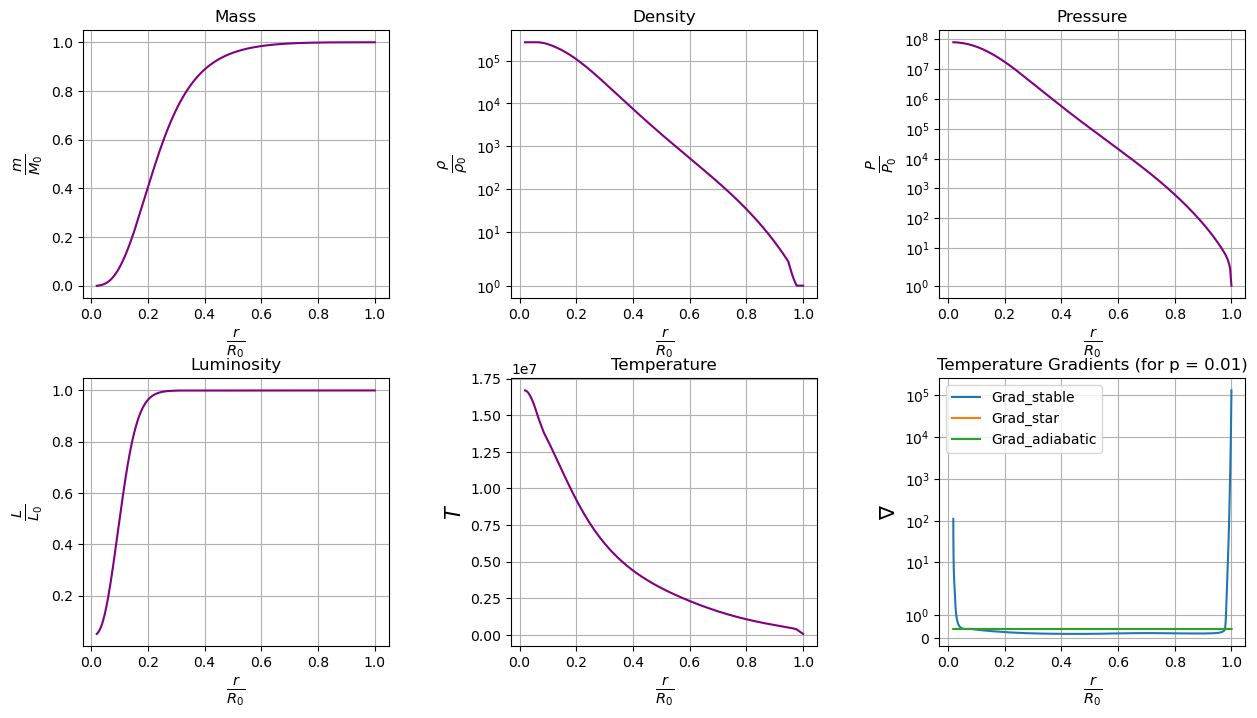

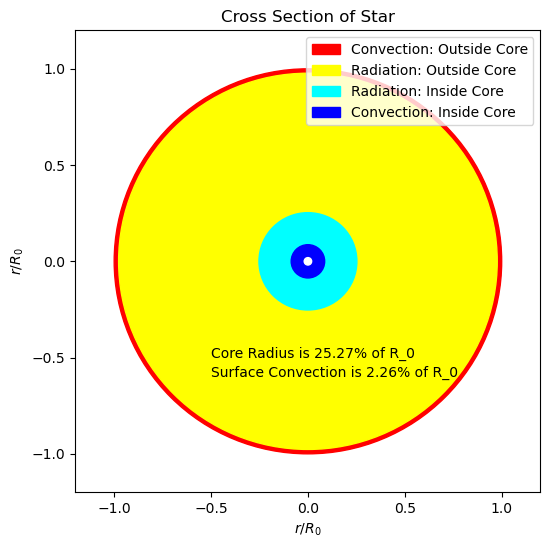

In [5]:
if __name__ == "__main__":
    # Create an instance of the Model class.
    model = Model()

    # Calculate variables and generate plots.
    r, m, rho, P, F, L, T, epsilon, grad_temp, grad_stable, grad_adiabatic, grad_star = model.ODE_euler()
    model.gen_plots(r, m, rho, P, L, T, grad_stable, grad_adiabatic, grad_star)
    model.plot_cross_star(r, L, grad_stable, grad_adiabatic)
    
    # >>> Sanity Check Test ---------------------------------|
    """
    UNCOMMENT THESE SIX LINES BELOW TO TEST THE SANITY CHECKS. MAKE SURE YOU HAVE ENABLE THE SANITY CHECKS (set to True) IN __init__ !
    If you run model.ODE_euler() with sanity checks enabled you will get a ton of output statements. 
    I suggest setting sanity checks to false before running model.ODE_euler().
    """
    # T_example = 5770
    # rho_example = 1.42*1e-7*model.rho_sun

    # kappa = model.calc_opacity(T_example, rho_example)
    # print(f"Calculated opacity: {kappa}") # Opacity

    # epsilon = model.calc_epsilon(T_example, rho_example)
    # print(f"Calculated epsilon: {epsilon}") # Epsilon
